In [4]:
import sys
sys.path.append("/Users/luo/OneDrive/SAR-Altimetry/sentinel3-altimetry-l2/utils")
import xarray as xr
import numpy as np
import os
from rsimage.tiff_io import readTiff
from osgeo import gdal
import matplotlib.pyplot as plt
from rsimage.imgShow import imgShow
from coor_convert import geo2imagexy


In [2]:
root_dir = os.path.dirname(os.getcwd())
dir_result = root_dir+'/results'
path_metrics_result = root_dir+'/results/metrics_result.nc'
path_rsimg = root_dir+'/data/rs_image/greatbay_l8_img.tif'


In [3]:
l8_img, im_geotrans, im_proj, im_row, im_col, im_bands = readTiff(path_rsimg)
img_gdal = gdal.Open(path_rsimg)


In [4]:
def acc_metric(ssha_estimate, ssha_truth):
    ## accuracy evaluation
    ind_valid = ~np.isnan(ssha_estimate)
    ssha_estimate_valid = ssha_estimate[ind_valid]
    ssha_truth_valid = ssha_truth[ind_valid]
    bias = (ssha_estimate_valid-ssha_truth_valid)
    bias_mean = np.mean(bias)
    std = abs(ssha_estimate_valid-ssha_truth_valid-bias_mean)
    std_mean = np.mean(std)
    coef = np.corrcoef(ssha_truth_valid, ssha_estimate_valid)
    return bias, bias_mean, std, std_mean, coef


In [17]:
retrackers = ['ocean', 'ocog', 'ice_sheet', 'sea_ice']
ssha_label = 'land_ransac_filter'   # nearest (valid footprint) filter or nearest ransac prediction

metrics_result = xr.Dataset()
for retracker in retrackers:
    path_result = os.path.join(dir_result, 'result_final_'+ retracker +'.nc')
    result_final = xr.open_dataset(path_result)
    ## valid value selection: diference between near tgauges <= 100 mm
    dif_tguage = result_final['tgauge_ssha_dif_near2'].values
    ind_valid_tgauge = np.where(abs(dif_tguage)<0.1)
    ## get the ssha variable and calculte the metrics.    
    ssha_estimate = result_final['ssha_'+ssha_label+'_'+retracker][ind_valid_tgauge]
    ssha_truth =  result_final['ssha_tgauge_interp'][ind_valid_tgauge]
    bias_ocean, bias_mean_ocean, std_ocean, std_mean_ocean, coef_ocean = acc_metric(ssha_estimate=ssha_estimate, ssha_truth=ssha_truth)
    metrics_result['bias_'+retracker] = np.around(bias_ocean.values,4)
    metrics_result['bias_mean_'+retracker] = np.around(bias_mean_ocean,4) 
    metrics_result['std_'+retracker] = np.around(std_ocean,4)
    metrics_result['std_mean_'+retracker] = np.around(std_mean_ocean,4)  
    metrics_result['coef_'+retracker] = np.around(coef_ocean[0,1],4)
# # writh to new .nc file
# metrics_result.to_netcdf(path=path_metrics_result)

print(ssha_label)
print('mean bias:', metrics_result['bias_mean_ocean'].values, metrics_result['bias_mean_ocog'].values, metrics_result['bias_mean_ice_sheet'].values,metrics_result['bias_mean_sea_ice'].values)
print('mean std:', metrics_result['std_mean_ocean'].values,metrics_result['std_mean_ocog'].values,metrics_result['std_mean_ice_sheet'].values,metrics_result['std_mean_sea_ice'].values)
print('coef:', metrics_result['coef_ocean'].values, metrics_result['coef_ocog'].values, metrics_result['coef_ice_sheet'].values,metrics_result['coef_sea_ice'].values)


land_ransac_filter
mean bias: -0.0818 0.2161 -0.0031 0.0076
mean std: 0.0724 0.0653 0.092 0.067
coef: 0.9838 0.9839 0.976 0.9865


## Compare different retracker-derived ssha  

In [6]:
result_final

<xarray.Dataset>
Dimensions:                                (echo_sample_ind: 128, lat_tgauge: 5, lon_tgauge: 5, tgauge_id: 1, time_20_ku: 50)
Coordinates:
  * time_20_ku                             (time_20_ku) datetime64[ns] 2019-0...
    lat_20_ku                              (time_20_ku) float64 ...
    lon_20_ku                              (time_20_ku) float64 ...
  * lon_tgauge                             (lon_tgauge) float64 114.2 ... 114.0
  * lat_tgauge                             (lat_tgauge) float64 22.3 ... 22.49
  * tgauge_id                              (tgauge_id) int64 0
Dimensions without coordinates: echo_sample_ind
Data variables: (12/137)
    UTC_day_20_ku                          (time_20_ku) datetime64[ns] ...
    UTC_sec_20_ku                          (time_20_ku) float64 ...
    UTC_time_1hz_20_ku                     (time_20_ku) datetime64[ns] ...
    lat_cor_20_ku                          (time_20_ku) float64 ...
    lon_cor_20_ku                          (time_20_ku) float64 ...
    surf_type_20_ku                        (time_20_ku) float32 ...
    ...                                     ...
    ssha_land_wf_ransac_filter_sea_ice     (time_20_ku) float64 ...
    ssha_land_ransac_pred_sea_ice          (time_20_ku) float64 ...
    ssha_wf_ransac_pred_sea_ice            (time_20_ku) float64 ...
    ssha_land_wf_ransac_pred_sea_ice       (time_20_ku) float64 ...
    ssha_tgauge_interp                     (time_20_ku) float64 ...
    tgauge_ssha_dif_near2                  (time_20_ku) float64 0.04 ... 0.28
Attributes: (12/44)
    Conventions:                       CF-1.6
    title:                             IPF SRAL/MWR Level 2 Measurement
    mission_name:                      Sentinel 3A
    altimeter_sensor_name:             SRAL
    radiometer_sensor_name:            MWR
    gnss_sensor_name:                  GNSS
    ...                                ...
    xref_iono_data:                    S3A_SR_2_RGI_AX_20190121T000000_201901...
    xref_mog2d_data:                   S3__SR_2_RMO_AX_20190121T000000_201901...
    xref_seaice_concentration:         S3__SR_2_SIC_AX_20190120T000000_201901...
    xref_altimeter_ltm:                S3A_SR_1_CA1LAX_20000101T000000_201909...
    xref_doris_uso:                    S3A_SR_1_USO_AX_20160223T195017_201912...
    xref_time_correlation:             S3A_AX___FRO_AX_20190121T000000_201901...

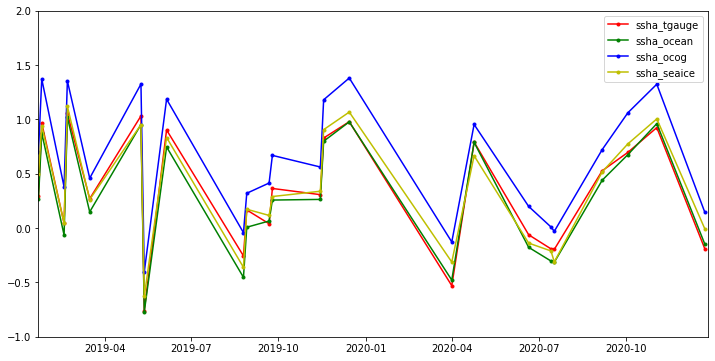

In [7]:
plt.figure(figsize=(12,6))
ssha_name =  'land_wf_ransac_pred'
plt.plot(result_final['time_20_ku'][ind_valid_tgauge], result_final['ssha_tgauge_interp'][ind_valid_tgauge],'r.-',label='ssha_tgauge')
plt.plot(result_final['time_20_ku'][ind_valid_tgauge], result_final['ssha_'+ssha_name+'_ocean'][ind_valid_tgauge],'g.-',label='ssha_ocean')
plt.plot(result_final['time_20_ku'][ind_valid_tgauge], result_final['ssha_'+ssha_name+'_ocog'][ind_valid_tgauge],'b.-',label='ssha_ocog')
plt.plot(result_final['time_20_ku'][ind_valid_tgauge], result_final['ssha_'+ssha_name+'_sea_ice'][ind_valid_tgauge],'y.-',label='ssha_seaice')
plt.axis([result_final['time_20_ku'][0], result_final['time_20_ku'][-1], -1, 7])
plt.axis([result_final['time_20_ku'][0],result_final['time_20_ku'][-1],-1,2])
plt.legend()


## Compare ransac prediction ssha and original ssha

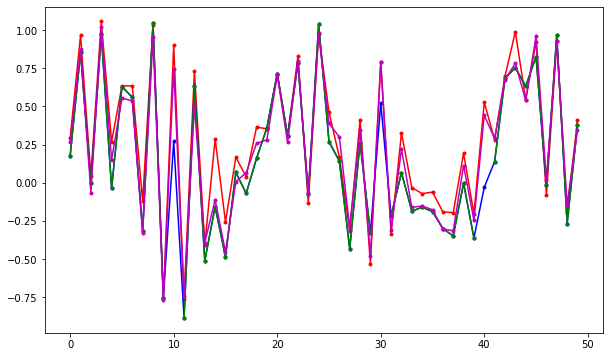

In [8]:
plt.figure(figsize=(10,6))
plt.plot(result_final['ssha_tgauge_interp'], 'r.-')
plt.plot(result_final['ssha_estimate_ocean'], 'b.-')
plt.plot(result_final['ssha_land_wf_ransac_filter_ocean'], 'g.-')
plt.plot(result_final['ssha_land_wf_ransac_pred_ocean'], 'm.-')


## Visualize the selected footprint 

<ipython-input-15-8d7cea80329e>:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.plot(col_tgauge[result_final['tgauge_id']], row_tgauge[result_final['tgauge_id']], 'r.', label='selected tgauge station')


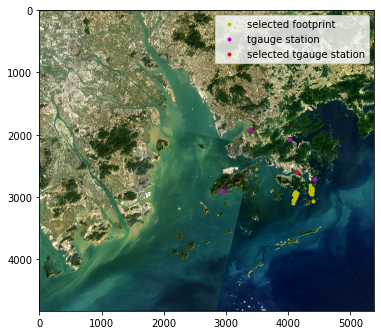

In [15]:
## get image coordinates (row,col).
col_fps, row_fps = geo2imagexy(lon=result_final['lon_20_ku'], lat=result_final['lat_20_ku'],img_gdal=img_gdal)
col_tgauge, row_tgauge = geo2imagexy(lon=result_final['lon_tgauge'], lat=result_final['lat_tgauge'],img_gdal=img_gdal)
plt.figure(figsize=(6,6))
imgShow(l8_img)
plt.plot(col_fps, row_fps, 'y.', label='selected footprint')
plt.plot(col_tgauge, row_tgauge, 'm.', label='tgauge station')
plt.plot(col_tgauge[result_final['tgauge_id']], row_tgauge[result_final['tgauge_id']], 'r.', label='selected tgauge station')
plt.legend()
